In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy import signal
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from numpy.linalg import inv
from helpers import Reconstruct, Viz_Y
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

In [32]:
samplerate_s, data_speech = read("../data/male_vocal.wav")
speech=data_speech[:10000,0]
speech_test=data_speech[10000:20000,0]
length=speech.shape[0]/samplerate_s
print('Shape of the speech {}'.format(speech.shape[0]))
print('Length : {:.2f}s'.format(length))
print('Sample rate : {}'.format(samplerate_s))

Shape of the speech 10000
Length : 0.23s
Sample rate : 44100


In [33]:
WINDOW = 'hamming'
WINDOW_SIZE=480
OVERLAP = 0.6 * WINDOW_SIZE
NFFT=512

f,t,Y= signal.stft(speech,samplerate_s,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_s=np.abs(Y)

f,t,Y_test= signal.stft(speech_test,samplerate_s,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_test=np.abs(Y_test)

print('Shape of spectrogram speech : {}'.format(Yabs_s.shape))


Shape of spectrogram speech : (257, 54)


In [28]:
n_components=8
model = NMF(n_components=n_components, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=10000, random_state=0)
B0 = model.fit_transform(Yabs_s)
G0 = model.components_

model = NMF(n_components=n_components, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=10000, random_state=0)
B1 = model.fit_transform(np.transpose(Yabs_s))
G1 = model.components_

In [29]:
print(Yabs_s.shape)
print(B0.shape)

(257, 54)
(257, 8)


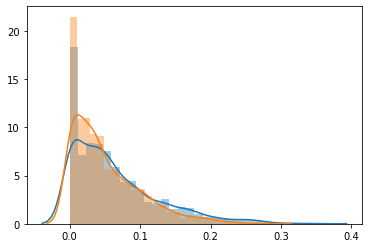

In [30]:
sns.distplot(B0)
sns.distplot(G1)

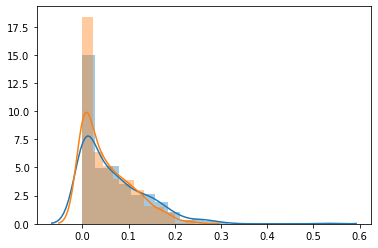

In [31]:
sns.distplot(B1)
sns.distplot(G0)

**We conclude that the fit_transform gives the B which has  a shape of 257*r**

# Check if the NMF freezes the B when doing a decomposition on test set:

In [50]:
n_components=2
model = NMF(n_components=n_components, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=10000, random_state=0)
B0 = model.fit_transform(np.transpose(Yabs_s))
G0 = model.components_

In [51]:
B1=model.transform(np.transpose(Yabs_test))
G1=model.components_

In [49]:
print(G0.shape)

(2, 257)


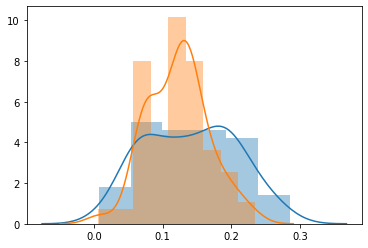

In [52]:
sns.distplot(B0)
sns.distplot(B1)

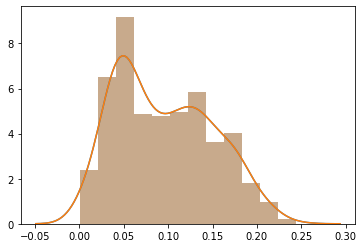

In [53]:
sns.distplot(G1)
sns.distplot(G0)

**In conclusion we must fit adn predict on the transposed spectrograms and inverse between B and G**

# N_componenets hyperparameter:

In [ ]:
losses=[]
N_COMP=[2,32,64,128]
for n_components in N_COMP:
    
    model = NMF(n_components=n_components, init='random',alpha=0.0,beta_loss='itakura-saito',solver="mu",max_iter=100, random_state=0)
    B = model.fit_transform(Yabs)
    G = model.components_
    losses.append(model.reconstruction_err_)
    print('N = {} ... Done ... '.format(n_components))
    
plt.plot(N_COMP,losses)